# MAGICC7

Pymagicc is also MAGICC7 compatible. 

As yet, the binary is not yet publicly available to it's a bit fiddlier to get setup. Here we give a minimal working example of how to use MAGICC7 with Pymagicc.

In [1]:
# NBVAL_IGNORE_OUTPUT

import pandas as pd
import pymagicc
from pymagicc import MAGICC6, MAGICC7
from pymagicc.io import MAGICCData

from pymagicc import rcp26, rcp45, rcp60, rcp85, scenarios

<IPython.core.display.Javascript object>

In [2]:
# NBVAL_IGNORE_OUTPUT
%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 16, 9

In [3]:
# set your environment to find your MAGICC binary
%env MAGICC_EXECUTABLE_7=../../magicc/run/magicc

env: MAGICC_EXECUTABLE_7=../../magicc/run/magicc


## The slow, easy way

Use the `pymagicc.run` API. This is super slow as it makes a new copy of the entire `magicc/run` directory for each run.

A few common issues when using your own setup are:
    - output flag settings may mean that you don't get the output you expect
    - super slow running as lots of output are being read back in (turn `OUT_XX` flags off to speed things up)
    - super slow running as your `out` directory is not empty before you run
    - your config file has more than one emissions scenario and/or config flag set (Pymagicc deliberately throws an error here to avoid difficult debugging of overlapping emissions and config inputs)
    
`MAGCFG_USER.CFG` should have lines like

```FORTRAN90
  FILE_EMISSCEN =  "NONE",
  FILE_EMISSCEN_2 =  "",
  FILE_EMISSCEN_3 =  "",
  FILE_EMISSCEN_4 =  "",
  FILE_EMISSCEN_5 =  "",
  FILE_EMISSCEN_6 =  "",
  FILE_EMISSCEN_7 =  "",
  FILE_EMISSCEN_8 =  "",
  FILE_TUNINGMODEL_1 =  "PYMAGICC",
  FILE_TUNINGMODEL_2 =  "USER",
  FILE_TUNINGMODEL_3 =  "USER",
  FILE_TUNINGMODEL_4 =  "USER",
  FILE_TUNINGMODEL_5 =  "USER",
  FILE_TUNINGMODEL_6 =  "USER",
  FILE_TUNINGMODEL_7 =  "USER",
  FILE_TUNINGMODEL_8 =  "USER",
  FILE_TUNINGMODEL_9 =  "USER",
  FILE_TUNINGMODEL_10 =  "USER",
```

In [4]:
for i, (name, scen) in enumerate(scenarios.items()):
    print("running {}".format(name))
    scen_results = pymagicc.run(scen, magicc_version=7)
    if i != 0:
        results.append(scen_results)
    else:
        results = scen_results

running RCP26
running RCP45
running RCP60
running RCP85


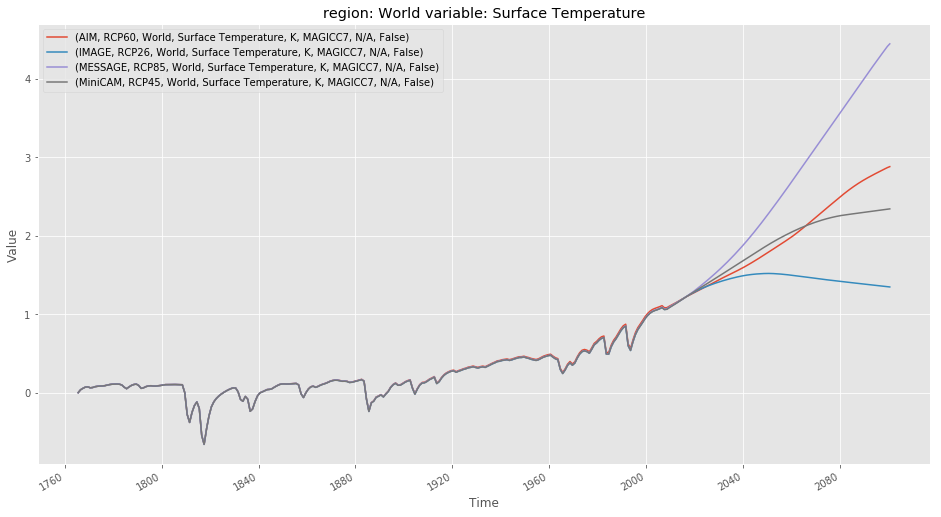

In [5]:
results.filter(variable="Surface Temperature", region="World").line_plot(
    x="time"
);

## The faster, mildly more difficult way

Use the context manager for the MAGICC version we want. This still creates a copy of the entire run folder, but only once.

running RCP26
running RCP45
running RCP60
running RCP85


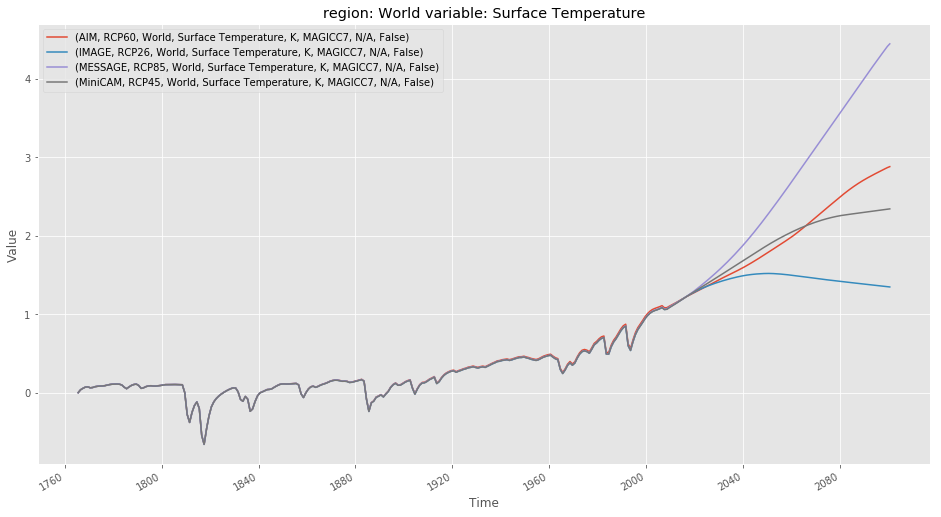

In [6]:
with MAGICC7() as magicc:
    for i, (name, scen) in enumerate(scenarios.items()):
        # note that we obviously don't need magicc_version as an argument
        # here as it is assigned automatically
        print("running {}".format(name))
        scen_results = magicc.run(scen)
        if i != 0:
            results.append(scen_results)
        else:
            results = scen_results

results.filter(variable="Surface Temperature", region="World").line_plot(
    x="time"
);

## The even faster, more dangerous and difficult to debug way

Use the context manager for the MAGICC version we want and specify the root directory. This doesn't create a copy of the entire run folder, but will modify files in place and hence alter any existing settings in your local copy.

running RCP26


unclosed file <_io.BufferedReader name='../../magicc/out/DAT_CH4_CONC.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_CH4_TAUOH.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_CH4_TAUTOT.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_CH4N_EMIS.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_CH4T_EMIS.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_N2O_CONC.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_N2O_TAUSCALE.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_N2O_TAUTOT.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_N2ON_EMIS.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_N2OT_EMIS.BINOUT'>
unclosed file <_io.BufferedReader name='../../magicc/out/DAT_SURFACE_TEMP.BINOUT'>


running RCP45
running RCP60
running RCP85


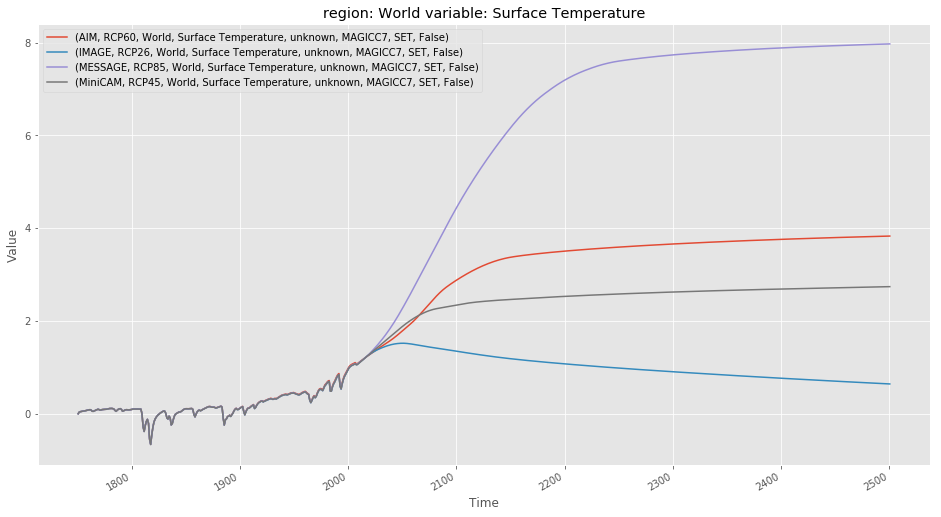

In [7]:
with MAGICC7(root_dir="../../magicc") as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=False,
        write_binary=True,
        keydata_2=True,
        emissions=False,
        parameters=True,
    )
    for i, (name, scen) in enumerate(scenarios.items()):
        # note that we obviously don't need magicc_version as an argument
        # here as it is assigned automatically
        print("running {}".format(name))
        scen_results = magicc.run(scen)
        if i != 0:
            results.append(scen_results)
        else:
            results = scen_results

results.filter(variable="Surface Temperature", region="World").line_plot(
    x="time"
);

## Comparing MAGICC6 and MAGICC7

Finally, we show how to easily compare MAGICC6 and MAGICC7. 

**Note** I've got strange settings in my local MAGICC7 folder so don't read anything into the plots.

In [8]:
for j, mclass in enumerate([MAGICC6, MAGICC7]):
    print("MAGICC{}".format(mclass.version))
    with mclass() as magicc:
        # binary readers aren't yet ready and we can't do this through
        # the run method just yet
        magicc.set_output_variables(
            write_ascii=True,
            write_binary=False,
            keydata_2=True,
            emissions=False,
            parameters=True,
        )
        for i, (name, scen) in enumerate(scenarios.items()):
            # note that we obviously don't need magicc_version as an argument
            # here as it is assigned automatically
            print("running {}".format(name))
            scen_results = magicc.run(scen)
            if (i != 0) or (j != 0):
                results.append(scen_results)
            else:
                results = scen_results

MAGICC6
running RCP26
running RCP45
running RCP60
running RCP85
MAGICC7
running RCP26
running RCP45
running RCP60
running RCP85


## Plotting options

When plotting climate model output, you often want to plot it with respect to some reference period. Here I propose two options for doing so.

Option 1 would add methods to OpenSCMDataFrame (or IamDataFrame)

In [9]:
# TODO: move into OpenSCMDataFrame or pyam
from pyam.plotting import reshape_line_plot


def get_reference_period_mean(df, reference_period, x="year", y="value"):
    ref_period_start, ref_period_end = reference_period
    assert (
        ref_period_start < ref_period_end
    ), "reference period must go from earlier to later"

    # type assertion on start and end?
    adf = reshape_line_plot(df, x=x, y=y)
    mdf = adf.loc[ref_period_start:ref_period_end].mean()

    return mdf


def adjust_to_baseline(mdata, reference_period, x="time", y="value"):
    ref_period_start, ref_period_end = reference_period
    assert (
        ref_period_start < ref_period_end
    ), "reference period must go from earlier to later"

    adf = reshape_line_plot(mdata.data.copy(), x=x, y=y)
    mdf = get_reference_period_mean(
        mdata.data.copy(), reference_period, x=x, y=y
    )

    bdf = adf - mdf

    ldf = bdf.T.stack(x).reset_index()
    ldf = ldf.rename({0: y}, axis="columns")

    #     # include?
    #     bstr = "{} to {} baseline".format(ref_period_start, ref_period_end)
    #     ldf["variable"] = ldf["variable"].apply(lambda x: "{} ({})".format(x, bstr))

    return MAGICCData(ldf)


def highlight_reference_period(ax, reference_period, **kwargs):
    ref_period_start, ref_period_end = reference_period
    assert (
        ref_period_start < ref_period_end
    ), "reference period must go from earlier to later"

    ax.axvspan(ref_period_start, ref_period_end, **kwargs)

    an_point_x = ref_period_start + (ref_period_end - ref_period_start) * 0.02
    (ymin, ymax) = ax.get_ylim()
    an_point_y = ymin + (ymax - ymin) * 0.01

    ax.annotate("Reference period", xy=(an_point_x, an_point_y))


def add_ylabel(ax, variable, unit, reference_period=None):
    ylabel = "{} ({})".format(variable, unit)

    if reference_period is not None:
        ref_period_start, ref_period_end = reference_period
        assert (
            ref_period_start < ref_period_end
        ), "reference period must go from earlier to later"
        ylabel = "{}\n(reference period: {} - {})".format(
            ylabel, ref_period_start, ref_period_end
        )

    ax.set_ylabel(ylabel)

    return ax


def line_plot(
    magiccdata,
    reference_period=None,
    x="time",
    y="value",
    highlight_kwargs={},
    **kwargs,
):
    if reference_period is not None:
        bdf = adjust_to_baseline(magiccdata, reference_period, x=x, y=y)
        ax = bdf.line_plot(x=x, y=y, **kwargs)
        highlight_reference_period(ax, reference_period, **highlight_kwargs)
    else:
        magiccdata.line_plot(**kwargs)

    add_ylabel(
        ax,
        magiccdata["variable"].iloc[0],
        magiccdata["unit"].iloc[0],
        reference_period,
    )

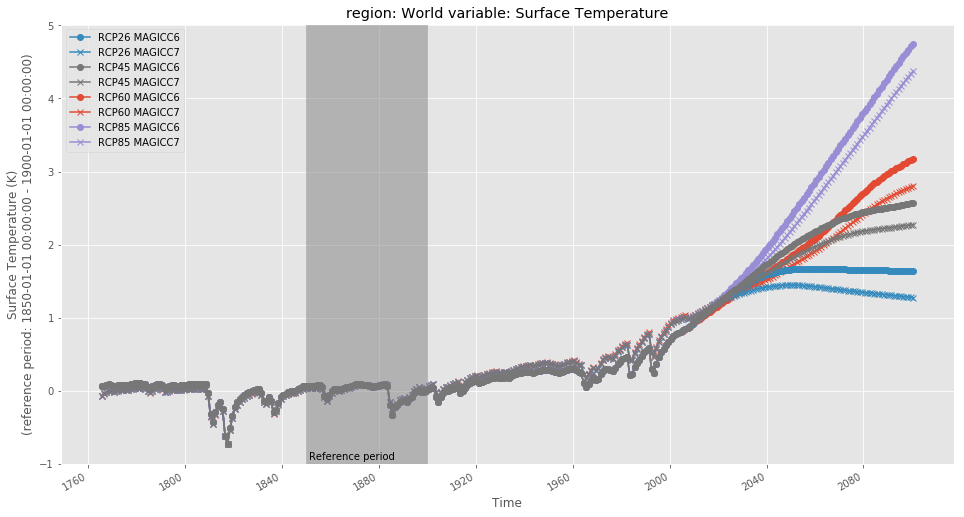

In [10]:
from datetime import datetime

line_plot(
    results.filter(variable="Surface Temperature", region="World"),
    (datetime(1850, 1, 1), datetime(1900, 1, 1)),
    highlight_kwargs={"color": "grey", "alpha": 0.5},
    color="scenario",
    marker="climate_model",
)

Option 2 uses seaborn instead:

In [11]:
import seaborn as sns

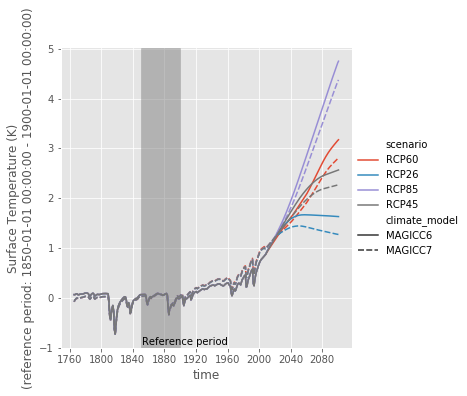

In [12]:
tempdf = results.filter(variable="Surface Temperature", region="World")
ref_period = (datetime(1850, 1, 1), datetime(1900, 1, 1))
bdf = adjust_to_baseline(tempdf, ref_period,)
fg = sns.relplot(
    x="time",
    y="value",
    kind="line",
    hue="scenario",
    style="climate_model",
    data=bdf.data,
)
ax = fg.axes[0][0]
highlight_reference_period(ax, ref_period, **{"color": "grey", "alpha": 0.5})
add_ylabel(ax, bdf["variable"].iloc[0], bdf["unit"].iloc[0], ref_period);